In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import classification_report
from tqdm.auto               import tqdm

In [ ]:
df = pd.read_csv('/kaggle/input/features-with-labels-csv/features_with_labels.csv')

print("► Gender distribution:\n", df['gender'].value_counts(), "\n")

► Gender distribution:
 gender
1    136992
0     35166
Name: count, dtype: int64 



In [ ]:
feature_cols = [
    'gender_f0_mean','gender_f0_std',
    'gender_formant_1','gender_formant_2','gender_formant_3',
    'gender_mfcc_0','gender_mfcc_1','gender_mfcc_2','gender_mfcc_3',
    'gender_mfcc_4','gender_mfcc_5','gender_mfcc_6','gender_mfcc_7',
    'gender_mfcc_8','gender_mfcc_9','gender_mfcc_10','gender_mfcc_11',
    'gender_mfcc_12',
    'gender_mfcc_d_0','gender_mfcc_d_1','gender_mfcc_d_2','gender_mfcc_d_3',
    'gender_mfcc_d_4','gender_mfcc_d_5','gender_mfcc_d_6','gender_mfcc_d_7',
    'gender_mfcc_d_8','gender_mfcc_d_9','gender_mfcc_d_10','gender_mfcc_d_11',
    'gender_mfcc_d_12',
    'gender_spec_contrast_0','gender_spec_contrast_1','gender_spec_contrast_2',
    'gender_spec_contrast_3','gender_spec_contrast_4','gender_spec_contrast_5',
    'gender_spec_contrast_6',
    'gender_chroma_0','gender_chroma_1','gender_chroma_2','gender_chroma_3',
    'gender_chroma_4','gender_chroma_5','gender_chroma_6','gender_chroma_7',
    'gender_chroma_8','gender_chroma_9','gender_chroma_10','gender_chroma_11'
]

min_count = df['gender'].value_counts().min()
print("Minority class size:", min_count)

balanced = pd.concat([
    df[df['gender'] == g].sample(n=min_count, random_state=42)
    for g in df['gender'].unique()
], axis=0)

balanced = balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("New distribution:\n", balanced['gender'].value_counts(), "\n")

X = balanced[feature_cols]
y = balanced['gender']

Minority class size: 35166
New distribution:
 gender
1    35166
0    35166
Name: count, dtype: int64 



In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline       import Pipeline
from sklearn.svm            import SVC
from xgboost                import XGBClassifier
from sklearn.ensemble       import StackingClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import accuracy_score, classification_report
from tqdm.auto             import tqdm

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:

xgb_pipe = Pipeline([
    ('poly',   PolynomialFeatures(degree=2,
                      interaction_only=True,
                      include_bias=False)),
    ('select', SelectKBest(f_classif)),  # k will be tuned
    ('scale',  StandardScaler()),        # scale before tree often still helps
    ('xgb',    XGBClassifier(random_state=42, n_jobs=1))
])

xgb_params = {
    'select__k':            [50, 100, 200, 300],
    'xgb__n_estimators':    [100, 200, 300],
    'xgb__max_depth':       [3, 5, 7],
    'xgb__learning_rate':   [0.05, 0.1, 0.2],
    'xgb__subsample':       [0.6, 0.8, 1.0],
    'xgb__colsample_bytree':[0.6, 0.8, 1.0],
}

xgb_search = GridSearchCV(
    xgb_pipe, xgb_params,
    cv=3, scoring='accuracy',
    n_jobs=1, verbose=1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("XGB CV:", xgb_search.best_score_, "→ Test:",
      accuracy_score(y_test, best_xgb.predict(X_test)))

svc_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svc',   SVC(probability=True))
])
svc_params = {
    'svc__C':     [0.1, 1, 10, 100],
    'svc__gamma': ['scale','auto', 0.001, 0.01, 0.1]
}

svc_search = GridSearchCV(
    svc_pipe, svc_params,
    cv=3, scoring='accuracy',
    n_jobs=1, verbose=1
)
svc_search.fit(X_train, y_train)
best_svc = svc_search.best_estimator_
print("SVC CV:", svc_search.best_score_, "→ Test:",
      accuracy_score(y_test, best_svc.predict(X_test)))

stack = StackingClassifier(
    estimators=[('xgb', best_xgb), ('svc', best_svc)],
    final_estimator=LogisticRegression(max_iter=2000),
    cv=3, n_jobs=1, passthrough=True
)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
print("\nStacking Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("XGBoost test acc:", accuracy_score(y_test, y_pred))


XGBoost test acc: 0.9404279519442668


In [10]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint, loguniform

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth':    randint(3, 12),
    'learning_rate': loguniform(1e-3, 1.0),
    'subsample':     [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':         [0, 0.5, 1, 5],
    'reg_alpha':     [0, 0.1, 1, 10],
    'reg_lambda':    [1, 10, 50]
}

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)  # no early stopping here

best_params = search.best_params_
print("Best params:", best_params)
print(f"Best CV acc: {search.best_score_:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.10988100318524599, 'max_depth': 11, 'n_estimators': 216, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best CV acc: 0.9397


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.preprocessing     import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition     import PCA
from sklearn.pipeline          import Pipeline
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.metrics           import classification_report, accuracy_score


pipelines = {
    'KNN_baseline': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(f_classif)),   # no fixed k yet
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca':      Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95)),
        ('knn',    KNeighborsClassifier())
    ]),
}

param_grids = {
    'KNN_baseline': {'knn__n_neighbors': [1,3,5,7,9,11,13]},
    'KNN_selectK': {
        'kbest__k':           [5, 10, 20, 30, 40, 50],  # <= total features
        'knn__n_neighbors':   [1,3,5,7,9,11,13]
    },
    'KNN_pca':     {'knn__n_neighbors': [1,3,5,7,9,11,13]}
}

best_models = {}
results = []

for name, pipe in tqdm(pipelines.items(), desc="Tuning pipelines"):
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    results.append({
        'pipeline': name,
        'best_params': grid.best_params_,
        'cv_acc':      grid.best_score_
    })

res_df = pd.DataFrame(results).sort_values('cv_acc', ascending=False)
print("CV results:")
print(res_df.to_string(index=False))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} - Test accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))


Tuning pipelines:   0%|          | 0/3 [00:00<?, ?it/s]

CV results:
    pipeline                             best_params   cv_acc
 KNN_selectK {'kbest__k': 40, 'knn__n_neighbors': 3} 0.942309
KNN_baseline                 {'knn__n_neighbors': 3} 0.939963
     KNN_pca                 {'knn__n_neighbors': 3} 0.935324

KNN_baseline - Test accuracy: 0.9431
              precision    recall  f1-score   support

           0     0.9281    0.9605    0.9440      7034
           1     0.9590    0.9256    0.9420      7033

    accuracy                         0.9431     14067
   macro avg     0.9436    0.9431    0.9430     14067
weighted avg     0.9436    0.9431    0.9430     14067


KNN_selectK - Test accuracy: 0.9458
              precision    recall  f1-score   support

           0     0.9307    0.9635    0.9468      7034
           1     0.9621    0.9282    0.9449      7033

    accuracy                         0.9458     14067
   macro avg     0.9464    0.9458    0.9458     14067
weighted avg     0.9464    0.9458    0.9458     14067


KNN_pca - 

In [12]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=False
)
cbc.fit(X_train, y_train, eval_set=(X_test,y_test))

y_pred = cbc.predict(X_test)
print("CatBoost test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


CatBoost test acc: 0.9418497192009668
              precision    recall  f1-score   support

           0     0.9406    0.9433    0.9419      7034
           1     0.9431    0.9404    0.9418      7033

    accuracy                         0.9418     14067
   macro avg     0.9419    0.9418    0.9418     14067
weighted avg     0.9419    0.9418    0.9418     14067



In [14]:
from sklearn.ensemble    import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline     import Pipeline
from sklearn.preprocessing import StandardScaler

# assume best_models['KNN_selectK'] exists and best_params from XGB search
xgb_clf = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

stack = StackingClassifier(
    estimators=[
        ('knn', best_models['KNN_selectK']),
        ('xgb', xgb_clf),
        ('rf',  RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=True    # gives meta-model also the original features
)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Stacking test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking test acc: 0.9597639866353878
              precision    recall  f1-score   support

           0     0.9599    0.9596    0.9598      7034
           1     0.9596    0.9599    0.9598      7033

    accuracy                         0.9598     14067
   macro avg     0.9598    0.9598    0.9598     14067
weighted avg     0.9598    0.9598    0.9598     14067



In [17]:
import pandas as pd
import joblib
joblib.dump(stack, "stacking_gender_model.joblib")
print("Saved stacking_gender_model.joblib")

Saved stacking_gender_model.joblib


In [15]:
param_grid = {
    'knn__n_neighbors': [1,3,5,7,9,11,13,15],
    'knn__weights':     ['uniform','distance'],
    'knn__algorithm':   ['auto','ball_tree','kd_tree'],
    'knn__leaf_size':   [20,30,40,50]
}
grid = GridSearchCV(best_models['KNN_selectK'], param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best KNN params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble       import StackingClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler

# rebuild your base estimators
xgb_clf = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

stack = StackingClassifier(
    estimators=[
        ('knn', best_models['KNN_selectK']),
        ('xgb', xgb_clf),
        ('rf',  RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ],
    # wrap the final estimator in a pipeline that scales + gives more iters
    final_estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('lr',     LogisticRegression(
                       solver='saga',       # faster on large data
                       max_iter=5000,       # plenty of room to converge
                       C=1.0,
                       random_state=42
                   ))
    ]),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Stacking test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

In [1]:
import pandas as pd
import joblib
from IPython.display import FileLink

In [ ]:
gender_df = pd.read_csv(
    '/kaggle/input/features-with-labels-csv/features_with_labels.csv',
    dtype={'path': str},       
    low_memory=False
)

# Age features
age_df = pd.read_csv(
    '/kaggle/input/data-with-features/data_with_features.csv',
    dtype={'path': str},       
    low_memory=False
)

print("Gender DF shape:", gender_df.shape)
print("Age    DF shape:", age_df.shape)

Gender DF shape: (172158, 179)
Age    DF shape: (172158, 217)


In [ ]:
merged = pd.merge(
    gender_df,
    age_df,
    on='path',
    how='inner'  
)
print("Merged shape:", merged.shape)

Merged shape: (172158, 395)


In [6]:
gender_features = [
  'gender_f0_mean','gender_f0_std',
  'gender_formant_1','gender_formant_2','gender_formant_3',
  'gender_mfcc_0','gender_mfcc_1','gender_mfcc_2','gender_mfcc_3',
  'gender_mfcc_4','gender_mfcc_5','gender_mfcc_6','gender_mfcc_7',
  'gender_mfcc_8','gender_mfcc_9','gender_mfcc_10','gender_mfcc_11',
  'gender_mfcc_12',
  'gender_mfcc_d_0','gender_mfcc_d_1','gender_mfcc_d_2','gender_mfcc_d_3',
  'gender_mfcc_d_4','gender_mfcc_d_5','gender_mfcc_d_6','gender_mfcc_d_7',
  'gender_mfcc_d_8','gender_mfcc_d_9','gender_mfcc_d_10','gender_mfcc_d_11',
  'gender_mfcc_d_12',
  'gender_spec_contrast_0','gender_spec_contrast_1','gender_spec_contrast_2',
  'gender_spec_contrast_3','gender_spec_contrast_4','gender_spec_contrast_5',
  'gender_spec_contrast_6',
  'gender_chroma_0','gender_chroma_1','gender_chroma_2','gender_chroma_3',
  'gender_chroma_4','gender_chroma_5','gender_chroma_6','gender_chroma_7',
  'gender_chroma_8','gender_chroma_9','gender_chroma_10','gender_chroma_11'
]

In [7]:
age_features = [
    # MFCC means 0–39
    'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3',
    'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7',
    'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11',
    'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15',
    'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 'mfcc_mean_19',
    'mfcc_mean_20', 'mfcc_mean_21', 'mfcc_mean_22', 'mfcc_mean_23',
    'mfcc_mean_24', 'mfcc_mean_25', 'mfcc_mean_26', 'mfcc_mean_27',
    'mfcc_mean_28', 'mfcc_mean_29', 'mfcc_mean_30', 'mfcc_mean_31',
    'mfcc_mean_32', 'mfcc_mean_33', 'mfcc_mean_34', 'mfcc_mean_35',
    'mfcc_mean_36', 'mfcc_mean_37', 'mfcc_mean_38', 'mfcc_mean_39',

    # MFCC vars 0–39
    'mfcc_var_0', 'mfcc_var_1', 'mfcc_var_2', 'mfcc_var_3',
    'mfcc_var_4', 'mfcc_var_5', 'mfcc_var_6', 'mfcc_var_7',
    'mfcc_var_8', 'mfcc_var_9', 'mfcc_var_10', 'mfcc_var_11',
    'mfcc_var_12', 'mfcc_var_13', 'mfcc_var_14', 'mfcc_var_15',
    'mfcc_var_16', 'mfcc_var_17', 'mfcc_var_18', 'mfcc_var_19',
    'mfcc_var_20', 'mfcc_var_21', 'mfcc_var_22', 'mfcc_var_23',
    'mfcc_var_24', 'mfcc_var_25', 'mfcc_var_26', 'mfcc_var_27',
    'mfcc_var_28', 'mfcc_var_29', 'mfcc_var_30', 'mfcc_var_31',
    'mfcc_var_32', 'mfcc_var_33', 'mfcc_var_34', 'mfcc_var_35',
    'mfcc_var_36', 'mfcc_var_37', 'mfcc_var_38', 'mfcc_var_39',

    # Mel-spec means 0–63
    'melspec_mean_0',  'melspec_mean_1',  'melspec_mean_2',  'melspec_mean_3',
    'melspec_mean_4',  'melspec_mean_5',  'melspec_mean_6',  'melspec_mean_7',
    'melspec_mean_8',  'melspec_mean_9',  'melspec_mean_10', 'melspec_mean_11',
    'melspec_mean_12', 'melspec_mean_13', 'melspec_mean_14', 'melspec_mean_15',
    'melspec_mean_16', 'melspec_mean_17', 'melspec_mean_18', 'melspec_mean_19',
    'melspec_mean_20', 'melspec_mean_21', 'melspec_mean_22', 'melspec_mean_23',
    'melspec_mean_24', 'melspec_mean_25', 'melspec_mean_26', 'melspec_mean_27',
    'melspec_mean_28', 'melspec_mean_29', 'melspec_mean_30', 'melspec_mean_31',
    'melspec_mean_32', 'melspec_mean_33', 'melspec_mean_34', 'melspec_mean_35',
    'melspec_mean_36', 'melspec_mean_37', 'melspec_mean_38', 'melspec_mean_39',
    'melspec_mean_40', 'melspec_mean_41', 'melspec_mean_42', 'melspec_mean_43',
    'melspec_mean_44', 'melspec_mean_45', 'melspec_mean_46', 'melspec_mean_47',
    'melspec_mean_48', 'melspec_mean_49', 'melspec_mean_50', 'melspec_mean_51',
    'melspec_mean_52', 'melspec_mean_53', 'melspec_mean_54', 'melspec_mean_55',
    'melspec_mean_56', 'melspec_mean_57', 'melspec_mean_58', 'melspec_mean_59',
    'melspec_mean_60', 'melspec_mean_61', 'melspec_mean_62', 'melspec_mean_63',

    # Mel-spec vars 0–63
    'melspec_var_0',  'melspec_var_1',  'melspec_var_2',  'melspec_var_3',
    'melspec_var_4',  'melspec_var_5',  'melspec_var_6',  'melspec_var_7',
    'melspec_var_8',  'melspec_var_9',  'melspec_var_10', 'melspec_var_11',
    'melspec_var_12', 'melspec_var_13', 'melspec_var_14', 'melspec_var_15',
    'melspec_var_16', 'melspec_var_17', 'melspec_var_18', 'melspec_var_19',
    'melspec_var_20', 'melspec_var_21', 'melspec_var_22', 'melspec_var_23',
    'melspec_var_24', 'melspec_var_25', 'melspec_var_26', 'melspec_var_27',
    'melspec_var_28', 'melspec_var_29', 'melspec_var_30', 'melspec_var_31',
    'melspec_var_32', 'melspec_var_33', 'melspec_var_34', 'melspec_var_35',
    'melspec_var_36', 'melspec_var_37', 'melspec_var_38', 'melspec_var_39',
    'melspec_var_40', 'melspec_var_41', 'melspec_var_42', 'melspec_var_43',
    'melspec_var_44', 'melspec_var_45', 'melspec_var_46', 'melspec_var_47',
    'melspec_var_48', 'melspec_var_49', 'melspec_var_50', 'melspec_var_51',
    'melspec_var_52', 'melspec_var_53', 'melspec_var_54', 'melspec_var_55',
    'melspec_var_56', 'melspec_var_57', 'melspec_var_58', 'melspec_var_59',
    'melspec_var_60', 'melspec_var_61', 'melspec_var_62', 'melspec_var_63'
]


In [9]:
stack_gender = joblib.load('/kaggle/input/stacking/stacking_gender_model.joblib')
male_age     = joblib.load('/kaggle/input/data-with-features/male_KNN_baseline_male.joblib')
female_age   = joblib.load('/kaggle/input/data-with-features/female_KNN_pca_female.joblib')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For mo

In [10]:
merged['predicted_gender'] = stack_gender.predict(merged[gender_features])

In [19]:
merged['predicted_age'] = None

male_mask   = merged['predicted_gender'] == 1
female_mask = merged['predicted_gender'] == 0

merged.loc[male_mask,   'predicted_age'] = male_age.predict(merged.loc[male_mask, age_features])
merged.loc[female_mask, 'predicted_age'] = female_age.predict(merged.loc[female_mask, age_features])

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [12]:
out_csv = "full_gender_age_predictions.csv"
merged.to_csv(out_csv, index=False)
print("Wrote:", out_csv)

Wrote: full_gender_age_predictions.csv


In [30]:
from sklearn.metrics import accuracy_score, classification_report

# 1) Gender accuracy
g_true = merged['gender_x']
g_pred = merged['predicted_gender'].astype(int)
print(f"Gender Accuracy: {accuracy_score(g_true, g_pred):.4f}")
print(classification_report(g_true, g_pred, target_names=['Female','Male'], digits=4))

# 2) Age accuracy
a_true = merged['age_x']
a_pred = merged['predicted_age'].astype(int)
print(f"Age Accuracy:    {accuracy_score(a_true, a_pred):.4f}")
print(classification_report(a_true, a_pred, target_names=['50s','20s'], digits=4))


Gender Accuracy: 0.9713
              precision    recall  f1-score   support

      Female     0.8837    0.9895    0.9336     35166
        Male     0.9972    0.9666    0.9817    136992

    accuracy                         0.9713    172158
   macro avg     0.9405    0.9780    0.9576    172158
weighted avg     0.9740    0.9713    0.9718    172158

Age Accuracy:    0.9812
              precision    recall  f1-score   support

         50s     0.9341    0.9705    0.9519     33117
         20s     0.9929    0.9837    0.9883    139041

    accuracy                         0.9812    172158
   macro avg     0.9635    0.9771    0.9701    172158
weighted avg     0.9816    0.9812    0.9813    172158



In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# 1) Initialize an array of the right shape
combined_pred = np.empty_like(g_pred, dtype=int)

# 2) Male, Twenties → 0
mask = (g_pred == 1) & (a_pred == 1)
combined_pred[mask] = 0

# 3) Female, Twenties → 1
mask = (g_pred == 0) & (a_pred == 1)
combined_pred[mask] = 1

# 4) Male, Fifties → 2
mask = (g_pred == 1) & (a_pred == 0)
combined_pred[mask] = 2

# 5) Female, Fifties → 3
mask = (g_pred == 0) & (a_pred == 0)
combined_pred[mask] = 3

# 6) Evaluate
print("Combined Accuracy:", accuracy_score(y_true, combined_pred))
print(classification_report(
    y_true, combined_pred,
    target_names=['Male-20s','Female-20s','Male-50s','Female-50s'],
    digits=4
))

Combined Accuracy: 0.9636206275630526
              precision    recall  f1-score   support

    Male-20s     0.9926    0.9615    0.9768    119700
  Female-20s     0.8651    0.9753    0.9169     19341
    Male-50s     0.9737    0.9481    0.9607     17292
  Female-50s     0.8849    0.9824    0.9311     15825

    accuracy                         0.9636    172158
   macro avg     0.9291    0.9668    0.9464    172158
weighted avg     0.9665    0.9636    0.9643    172158



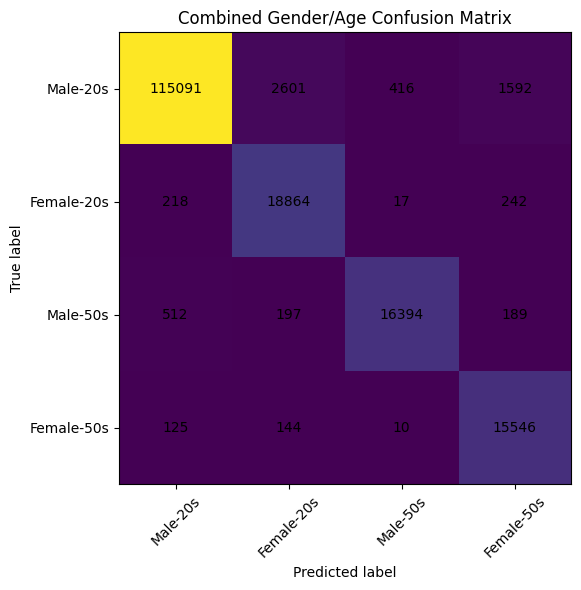

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, combined_pred)

# Class names in your label order
labels = ['Male-20s','Female-20s','Male-50s','Female-50s']

# Plot
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Combined Gender/Age Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)

# Annotate each cell with its count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 verticalalignment='center')

plt.tight_layout()
plt.show()


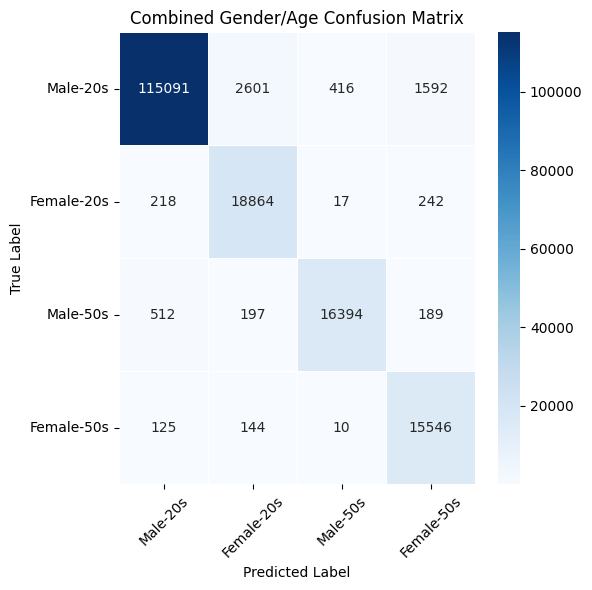

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# assume y_true and combined_pred are already defined
labels = ['Male-20s','Female-20s','Male-50s','Female-50s']
cm = confusion_matrix(y_true, combined_pred)

plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Combined Gender/Age Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
